In [125]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from tqdm import tqdm

import random
from pprint import pprint

## Train-Test-Split

In [2]:
def train_test_split(df, test_size):

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

## Data Pure?

In [3]:
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

## CLassify

In [4]:
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(
        label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

## Potential splits

In [42]:
def get_potential_splits(data, random_subspace):

    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))

    if (random_subspace) and (random_subspace <= len(column_indices)):
        column_indices = random.sample(
            population=column_indices,
            k=random_subspace,
        )
    for column_index in column_indices:
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values

    return potential_splits

## Split Data

In [6]:
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values > split_value]

    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above

$S_{i} = - \sum_{k=1}^{n} P_{i,k}\log_{2}P_{i,k}$ \
$S_{overall} =  \sum_{i=1}^{2} P_{i}  \cdot S_{i} $

In [7]:
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [8]:
def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                       + p_data_above * calculate_entropy(data_above))

    return overall_entropy

In [9]:
def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(
                data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(
                data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value

## Determine Type of Feature

In [10]:
def determine_type_of_feature(df):

    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return feature_types

## Algorithm

In [49]:

def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):

    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df

    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification

    # recursive part
    else:
        counter += 1

        potential_splits = get_potential_splits(data, random_subspace)

        split_column, split_value = determine_best_split(
            data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)

        else:
            question = "{} = {}".format(feature_name, split_value)

        sub_tree = {question: []}

        yes_answer = decision_tree_algorithm(
            data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(
            data_above, counter, min_samples, max_depth, random_subspace)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree

## Classification

In [12]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    featuer_name, comparison_operator, value = question.split(' ')

    if comparison_operator == '<=':
        if example[featuer_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[featuer_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    if not isinstance(answer, dict):
        return answer

    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [61]:
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(classify_example, args=(tree,), axis=1)
    return predictions

## Accuracy

In [13]:
def calculate_accuracy(df, tree):
    df['classification'] = df.apply(
        classify_example,
        axis=1,
        args=(tree,)
    )
    df['classidication_correct'] = df.classification == df.label
    accuracy = df.classidication_correct.mean()
    return accuracy

# Data Set

In [98]:

df = pd.read_csv("./dataset/Stars.csv")
df = df.rename(columns={
    'Temperature (K)': 'T',
    'Luminosity(L/Lo)': 'L',
    'Radius(R/Ro)': 'R',
    'Absolute magnitude(Mv)': 'Mv',
    'Star color': 'color',
    'Spectral Class': 'class',
    'Star type': 'type',
})
df['label'] = df.type
df = df.drop(['type'], axis=1)
df = df.drop(['color', 'class'], axis=1)

In [119]:
total_features = df.shape[1] - 1
df.head()

,T,L,R,Mv,label
0,3068,0.002400,0.1700,16.12,0
1,3042,0.000500,0.1542,16.60,0
2,2600,0.000300,0.1020,18.70,0
3,2800,0.000200,0.1600,16.65,0
4,1939,0.000138,0.1030,20.06,0


In [100]:
random.seed(0)

train_df, test_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(train_df, max_depth=3)
accuracy = calculate_accuracy(test_df, tree)

pprint(tree, width=50)
print(accuracy)

{'Mv <= 6.228': [{'Mv <= -7.58': [5.0,
                                  {'Mv <= -5.24': [4.0,
                                                   3.0]}]},
                 {'Mv <= 14.94': [{'R <= 0.015': [2.0,
                                                  1.0]},
                                  0.0]}]}
0.9791666666666666


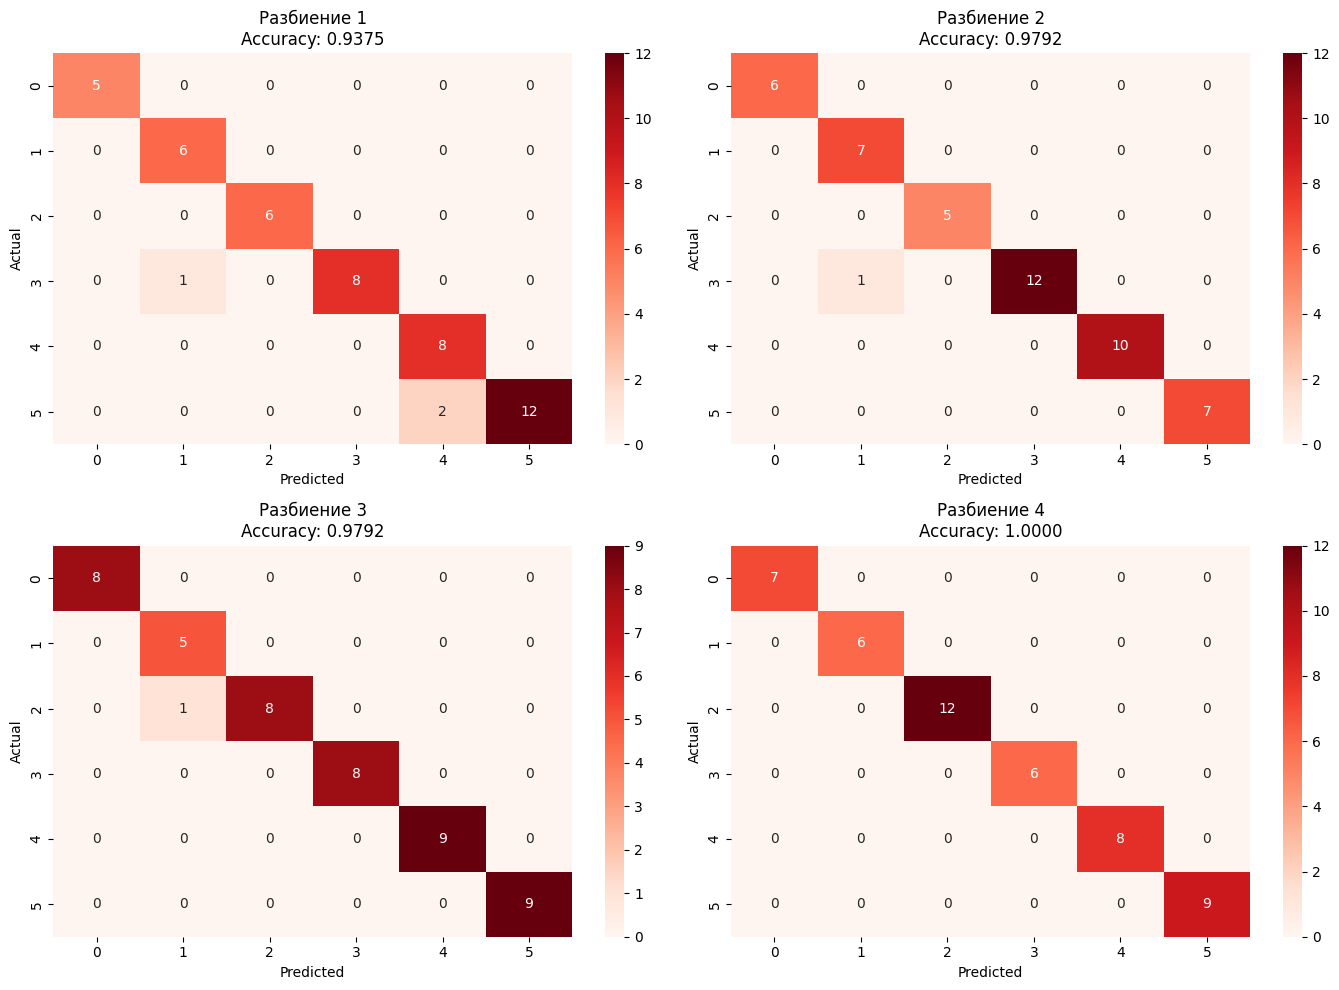

In [102]:
split_accuracies = []
split_confusion_matrices = []

n_splits = 4

for i in range(n_splits):

    train_df, test_df = train_test_split(df, test_size=0.2)

    tree = decision_tree_algorithm(train_df, max_depth=3)
    accuracy = calculate_accuracy(test_df, tree)

    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label']

    y_pred = [classify_example(X_test.iloc[j], tree)
              for j in range(len(X_test))]

    cm = confusion_matrix(y_test, y_pred)

    split_accuracies.append(accuracy)
    split_confusion_matrices.append(cm)

fig, axes = plt.subplots(2, n_splits // 2, figsize=(14, 10))

for i, cm in enumerate(split_confusion_matrices):
    row = i // 2
    col = i % 2
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', ax=axes[row, col])
    axes[row, col].set_title(
        f'Разбиение {i + 1}\nAccuracy: {split_accuracies[i]:.4f}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Random Forest

In [112]:
def bootstrapping(train_df, n_bootstrap):
    # bootstrap_indices = np.random.randint(
    #     low=0,
    #     high=len(train_df),
    #     size=n_bootstrap
    # )
    # df_bootstrapped = train_df.iloc[bootstrap_indices]

    df_bootstrapped = train_df.sample(
        n=n_bootstrap, replace=True, random_state=random.randint(0, 10000))

    return df_bootstrapped

In [104]:
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(
            df_bootstrapped,
            max_depth=dt_max_depth,
            random_subspace=n_features
        )
        forest.append(tree)

    return forest

In [105]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = f'tree_{i}'
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]

    return random_forest_predictions

In [106]:
def get_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()

    return accuracy

In [107]:
forest = random_forest_algorithm(
    train_df,
    n_trees=4,
    n_bootstrap=len(train_df),
    n_features=999,
    dt_max_depth=10
)

predictions = random_forest_predictions(test_df, forest)
accuracy = get_accuracy(predictions, test_df.label)
print(accuracy)

1.0


In [123]:
accuracies = []
for i in range(10):
    forest = random_forest_algorithm(
        train_df,
        n_trees=10,
        n_bootstrap=len(train_df),
        n_features=round(np.sqrt(total_features)),
        dt_max_depth=4
    )

    predictions = random_forest_predictions(test_df, forest)
    accuracy = get_accuracy(predictions, test_df.label)
    accuracies.append(accuracy)
print(f'avarage accuracy: {np.array(accuracies).mean()}')

avarage accuracy: 0.9916666666666666


1 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Средняя точность: 0.931250


2 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Средняя точность: 0.947917


3 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Средняя точность: 0.966667


4 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Средняя точность: 0.966667


5 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Средняя точность: 0.966667


6 trees, accuracy: 1.0000: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Средняя точность: 0.979167


7 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Средняя точность: 0.975000


8 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Средняя точность: 0.983333


9 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Средняя точность: 0.981250


10 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Средняя точность: 0.983333


11 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Средняя точность: 0.975000


12 trees, accuracy: 1.0000: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Средняя точность: 0.981250


13 trees, accuracy: 0.9792: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Средняя точность: 0.975000


14 trees, accuracy: 0.9583: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


Средняя точность: 0.983333


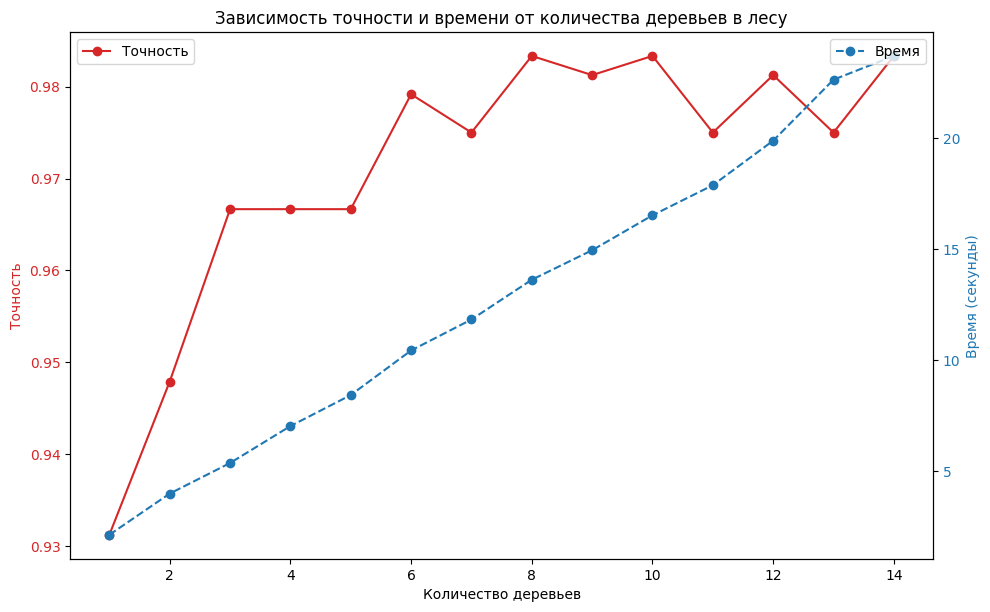

In [144]:

accuracies = []
times = []
n_trees_list = list(range(1, 15))


for n_trees in n_trees_list:
    start_time = time.time()
    j_accuracies = []
    pbar = tqdm(range(10), desc=f"{n_trees} trees in forest")
    for i in pbar:
        forest = random_forest_algorithm(
            train_df,
            n_trees=n_trees,
            n_bootstrap=len(train_df),
            n_features=round(np.sqrt(total_features)),
            dt_max_depth=4
        )

        predictions = random_forest_predictions(test_df, forest)
        accuracy = get_accuracy(predictions, test_df.label)
        j_accuracies.append(accuracy)
        pbar.set_description(f'{n_trees} trees, accuracy: {accuracy:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    times.append(elapsed_time)
    mean_accuracies = np.array(j_accuracies).mean()
    accuracies.append(mean_accuracies)
    print(f'Средняя точность: {mean_accuracies:.6f}')

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Количество деревьев')
ax1.set_ylabel('Точность', color=color)
ax1.plot(n_trees_list, accuracies, color=color, marker='o', label='Точность')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Время (секунды)', color=color)
ax2.plot(n_trees_list, times, color=color,
         marker='o', linestyle='--', label='Время')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Зависимость точности и времени от количества деревьев в лесу')
plt.show()

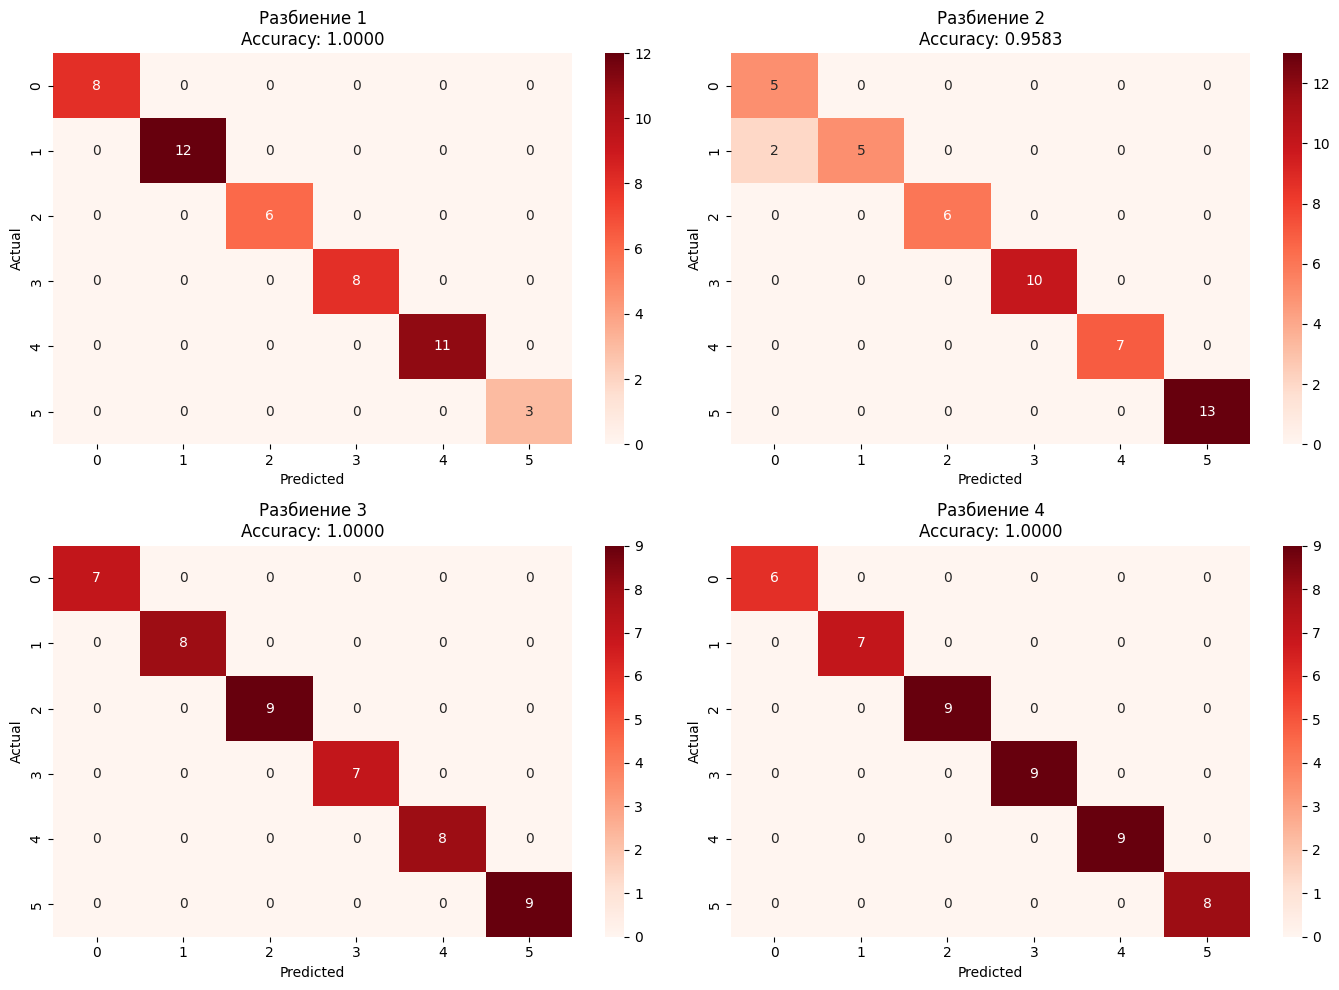

In [142]:
split_accuracies = []
split_confusion_matrices = []

n_splits = 4

for i in range(n_splits):

    train_df, test_df = train_test_split(df, test_size=0.2)

    forest = random_forest_algorithm(
        train_df,
        n_trees=10,
        n_bootstrap=len(train_df),
        n_features=round(np.sqrt(total_features)),
        dt_max_depth=4
    )
    accuracy = get_accuracy(random_forest_predictions(
        test_df, forest), test_df['label'])

    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label']

    y_pred = random_forest_predictions(X_test, forest)

    cm = confusion_matrix(y_test, y_pred)

    split_accuracies.append(accuracy)
    split_confusion_matrices.append(cm)

fig, axes = plt.subplots(2, n_splits // 2, figsize=(14, 10))

for i, cm in enumerate(split_confusion_matrices):
    row = i // 2
    col = i % 2
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', ax=axes[row, col])
    axes[row, col].set_title(
        f'Разбиение {i + 1}\nAccuracy: {split_accuracies[i]:.4f}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

plt.tight_layout()
plt.show()